In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

In [24]:
# 讀取資料
vix_df = pd.read_csv("VIX_History.csv", parse_dates=['Date'])
txf_df  = pd.read_csv('TXF_R1_1min_data_combined.csv', parse_dates=['datetime'])
settlement_df = pd.read_csv('settlement_date.csv', encoding='utf-16', parse_dates=['datetime'])
# df_0050 = pd.read_excel("0050.xlsx")

In [25]:
# 篩選日盤時間
txf_df = txf_df[
    (txf_df['datetime'].dt.time >= pd.to_datetime('08:45').time()) &
    (txf_df['datetime'].dt.time <= pd.to_datetime('13:45').time())
]
txf_df = txf_df[(txf_df['datetime'] >= '2009-01-01') & (txf_df['datetime'] <= '2025-06-30')]
# 新增一欄日期方便 groupby（只保留年月日）
txf_df['date'] = txf_df['datetime'].dt.date

# 聚合當日日盤資料
txf_df = txf_df.groupby('date').agg(
    Open=('Open', 'first'),
    High=('High', 'max'),
    Low=('Low', 'min'),
    Close=('Close', 'last')
).reset_index()

# 若你想把 date 轉回 datetime
txf_df['datetime'] = pd.to_datetime(txf_df['date'])

# 篩選回測期間的settlement資料
settlement_df = settlement_df[(settlement_df['datetime'] >= '2009-01-01') & (settlement_df['datetime'] <= '2025-06-30')]


In [26]:
# 將VIX時間與台灣時間對齊
vix_df = vix_df.rename(columns={'Close': 'VIX'}).fillna(0)
vix_df = vix_df.rename(columns={'Date': 'datetime'}).fillna(0)
vix_df = vix_df[['datetime', 'VIX']]
vix_df['datetime'] = pd.to_datetime(vix_df['datetime']) + pd.Timedelta(days=1)

# 將資料標準化
vix_df['datetime'] = pd.to_datetime(vix_df['datetime']).dt.normalize()

# 合併資料
txf_df = pd.merge(txf_df, vix_df, on='datetime', how='left')
txf_df = txf_df.sort_values('datetime')
txf_df.ffill(inplace=True)
txf_df.at[0, 'VIX'] = 39.19

# 紀錄市場報酬
market_df = txf_df.copy()

In [27]:
# 技術指標計算
txf_df['High10'] = txf_df['High'].rolling(10).max()
txf_df['Low10'] = txf_df['Low'].rolling(10).min()
txf_df['%R'] = (txf_df['High10'] - txf_df['Close']) / (txf_df['High10'] - txf_df['Low10']) * -100

# txf_df['VIX_10d_max'] = txf_df['VIX'].rolling(3).max()
# txf_df['VIX_10d_new_high'] = txf_df['VIX'] == txf_df['VIX_10d_max']
# txf_df.drop(columns=['VIX_10d_max'], inplace=True)

In [28]:
# 建立日期欄位(處理換月問題)
rollover_dates = set(pd.to_datetime(settlement_df['datetime']).dt.normalize())

In [29]:
# 永遠只能持有一口(遇到新的進場訊號要先把舊的部位出掉)
# 初始化欄位
txf_df['PositionRaw'] = 0
txf_df['EntrySignal'] = 0
txf_df['ExitSignal'] = 0
txf_df['PnL'] = 0.0
txf_df['Cost'] = 0.0
txf_df['NetPnL'] = 0.0
txf_df['Equity'] = 1_000_000.0
txf_df['TradeReturn'] = 0.0
txf_df['TradingDate'] = 0
txf_df['Rollover'] = 0
txf_df['EntryPrice'] = None
txf_df['ExitPrice'] = None

# 參數
position = 0
fee_per_trade = 0.0003      # 單邊費率
capital = 1_000_000.0
contract_size = 200

pending_entry = False
pending_exit = False

def side_cost(price):
    return fee_per_trade * contract_size * price

for i in range(1, len(txf_df)):
    prev_row = txf_df.iloc[i - 1]
    row = txf_df.iloc[i]

    cost_today = 0.0
    pnl = 0.0
    is_rollover = row['datetime'] in rollover_dates
    rollover_executed = False

    # 出場處理（隔天開盤）
    if pending_exit:
        exit_price = row['Open']
        pnl += (exit_price - prev_row['Close']) * contract_size
        cost_today += side_cost(exit_price)
        position = 0
        pending_exit = False
        txf_df.at[i, 'ExitPrice'] = exit_price

    # 換倉日（有部位才動作）
    if is_rollover and position > 0:
        exit_price = row['Open']
        pnl += (exit_price - prev_row['Close']) * contract_size
        cost_today += side_cost(exit_price)       # 平倉
        txf_df.at[i, 'ExitPrice'] = exit_price

        entry_price = row['Open']
        cost_today += side_cost(entry_price)      # 再開倉
        txf_df.at[i, 'EntryPrice'] = entry_price

        rollover_executed = True
        txf_df.at[i, 'Rollover'] = 1

        # 今日持有 → 收盤也要算損益
        pnl += (row['Close'] - row['Open']) * contract_size

    # 進場處理（隔天開盤）
    if pending_entry and position == 0:
        entry_price = row['Open']
        position = 1
        cost_today += side_cost(entry_price)
        pnl += (row['Close'] - row['Open']) * contract_size
        pending_entry = False
        txf_df.at[i, 'EntryPrice'] = entry_price

    # 一般持倉 
    elif position > 0 and not rollover_executed:
        pnl += (row['Close'] - prev_row['Close']) * contract_size

    #  更新資金 
    net_pnl = pnl - cost_today
    trade_return = net_pnl / capital if capital > 0 else 0.0
    capital += net_pnl

    # 存入 DataFrame
    txf_df.at[i, 'PnL'] = pnl
    txf_df.at[i, 'Cost'] = cost_today
    txf_df.at[i, 'NetPnL'] = net_pnl
    txf_df.at[i, 'TradeReturn'] = trade_return
    txf_df.at[i, 'Equity'] = capital
    txf_df.at[i, 'PositionRaw'] = position

    #  產生下一天 pending 訊號 
    if i < len(txf_df) - 1:
        long_signal = (row['%R'] < -95) and (row['VIX'] > 18)
        exit_signal = (row['%R'] > -1)

        if position > 0 and (exit_signal or long_signal):
            pending_exit = True
            txf_df.at[i, 'ExitSignal'] = 1

        if long_signal:
            pending_entry = True
            txf_df.at[i, 'EntrySignal'] = 1

# 標記交易期間
in_trade = False
for i in range(len(txf_df)):
    if txf_df.at[i, 'PositionRaw'] == 1 and not in_trade:
        in_trade = True
    if in_trade:
        txf_df.at[i, 'TradingDate'] = 1
    if in_trade and txf_df.at[i, 'PositionRaw'] == 0 and (i > 0 and txf_df.at[i - 1, 'PositionRaw'] == 1):
        in_trade = False

In [30]:
# 沒辦法加碼版本
trades = []

# 抓所有進場和出場訊號的 index
entry_indices = txf_df.index[txf_df['EntrySignal'] == 1].tolist()
exit_indices  = txf_df.index[txf_df['ExitSignal']  == 1].tolist()

# 確保配對數量一致
num_trades = min(len(entry_indices), len(exit_indices))

for i in range(num_trades):
    start_idx = entry_indices[i]
    end_idx   = exit_indices[i]

    # 進場價格 = 進場訊號後的隔日開盤
    entry_idx = start_idx + 1 if start_idx + 1 < len(txf_df) else start_idx
    entry_price = txf_df.at[entry_idx, 'Open']
    entry_date  = txf_df.at[entry_idx, 'datetime']

    # 出場價格 = 出場訊號後的隔日開盤
    exit_idx = end_idx + 1 if end_idx + 1 < len(txf_df) else end_idx
    exit_price = txf_df.at[exit_idx, 'Open']
    exit_date  = txf_df.at[exit_idx, 'datetime']

    # 自己算的 PnL
    trade_pnl = (exit_price - entry_price) * 200

    # 成本計算
    buy_cost = entry_price * 200 * 0.0003
    sell_cost = exit_price * 200 * 0.0003

    # 換月成本
    rollover_cost = 0
    rollover_count = 0
    if 'settlement_df' in globals():
        # 找交易期間內的換月日期
        rollover_days = settlement_df[(settlement_df['datetime'] > entry_date) & 
                                      (settlement_df['datetime'] <= exit_date)]
        rollover_count = len(rollover_days)
        for idx, row in rollover_days.iterrows():
            rollover_date = row['datetime']
            # 找 txf_df 對應日期的開盤價
            open_price = txf_df.loc[txf_df['datetime'] == rollover_date, 'Open'].values[0]
            rollover_cost += open_price * 200 * 0.0003 * 2

    # 總成本
    trade_cost = buy_cost + sell_cost + rollover_cost

    # NetPnL
    trade_netpnl = trade_pnl - trade_cost

    # 持倉天數
    holding_days = (exit_date - entry_date).days + 1  # 包含進出場當日

    trades.append({
        'EntryDate':    entry_date,
        'EntryPrice':   entry_price,
        'ExitDate':     exit_date,
        'ExitPrice':    exit_price,
        'PnL':          trade_pnl,
        'Cost':         trade_cost,
        'NetPnL':       trade_netpnl,
        'RolloverCount': rollover_count,
        'HoldingDays':   holding_days
    })

trades_df = pd.DataFrame(trades)
print(trades_df)


    EntryDate  EntryPrice   ExitDate  ExitPrice       PnL     Cost     NetPnL  \
0  2009-01-16      4277.0 2009-03-24     5201.0  184800.0  2186.16  182613.84   
1  2009-04-29      5648.0 2009-05-05     6637.0  197800.0   737.10  197062.90   
2  2009-06-10      6458.0 2009-06-16     6173.0  -57000.0   757.86  -57757.86   
3  2009-06-16      6173.0 2009-09-08     7250.0  215400.0  3166.02  212233.98   
4  2009-10-29      7360.0 2009-11-12     7695.0   67000.0   903.30   66096.70   
..        ...         ...        ...        ...       ...      ...        ...   
87 2024-08-06     20395.0 2024-09-20    22345.0  390000.0  7849.32  382150.68   
88 2025-04-01     21000.0 2025-04-08    18596.0 -480800.0  2375.76 -483175.76   
89 2025-04-08     18596.0 2025-04-09    17846.0 -150000.0  2186.52 -152186.52   
90 2025-04-09     17846.0 2025-04-10    18902.0  211200.0  2204.88  208995.12   
91 2025-04-10     18902.0 2025-06-12    22315.0  682600.0  7412.82  675187.18   

    RolloverCount  HoldingD

In [31]:
def calc_metrics(df, trades):
    if len(df) < 2:
        return {
            'CAGR': np.nan, 'Volatility': np.nan, 'Sharpe': np.nan,
            'MaxDrawdown': np.nan, 'WinRate': np.nan, 'PLRatio': np.nan
        }

    # 總天數 & 年數
    total_days = (df['datetime'].iloc[-1] - df['datetime'].iloc[0]).days
    years = total_days / 365.0 if total_days > 0 else 1

    # CAGR
    cagr = (df['Equity'].iloc[-1] / df['Equity'].iloc[0]) ** (1 / years) - 1

    # 日報酬率
    daily_returns = df['Equity'].pct_change().dropna()

    # 年化波動率
    annual_vol = daily_returns.std() * np.sqrt(252) if not daily_returns.empty else np.nan

    # 夏普比率
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else np.nan

    # 最大回撤
    roll_max = df['Equity'].cummax()
    drawdown = (df['Equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()

    # 勝率 & 賺賠比
    if len(trades) > 0:
        win_rate = (trades['NetPnL'] > 0).sum() / len(trades)

        avg_win = trades.loc[trades['NetPnL'] > 0, 'NetPnL'].mean()
        avg_loss = trades.loc[trades['NetPnL'] < 0, 'NetPnL'].mean()

        if pd.notna(avg_win) and pd.notna(avg_loss) and avg_loss != 0:
            pl_ratio = avg_win / abs(avg_loss)
        else:
            pl_ratio = np.nan
    else:
        win_rate = np.nan
        pl_ratio = np.nan

    return {
        'CAGR': cagr,
        'Volatility': annual_vol,
        'Sharpe': sharpe,
        'MaxDrawdown': max_drawdown,
        'WinRate': win_rate,
        'PLRatio': pl_ratio
    }


# 分樣本
cutoff = pd.to_datetime("2020-01-01")

# 分 Equity
df_in  = txf_df[txf_df['datetime'] <  cutoff].copy()
df_out = txf_df[txf_df['datetime'] >= cutoff].copy()
df_all = txf_df.copy()

# 分交易
trades_in  = trades_df[trades_df['EntryDate'] <  cutoff]
trades_out = trades_df[trades_df['EntryDate'] >= cutoff]
trades_all = trades_df.copy()

# 計算
metrics_in  = calc_metrics(df_in, trades_in)
metrics_out = calc_metrics(df_out, trades_out)
metrics_all = calc_metrics(df_all, trades_all)

# 整理成表格
metrics_df = pd.DataFrame({
    'In-Sample': metrics_in,
    'Out-of-Sample': metrics_out,
    'Full Sample': metrics_all
})

print(metrics_df)


             In-Sample  Out-of-Sample  Full Sample
CAGR          0.091774       0.092932     0.092128
Volatility    0.102613       0.150267     0.120372
Sharpe        0.925576       0.689991     0.812636
MaxDrawdown  -0.207106      -0.294360    -0.294360
WinRate       0.615385       0.375000     0.510870
PLRatio       1.976842       2.959982     2.046953


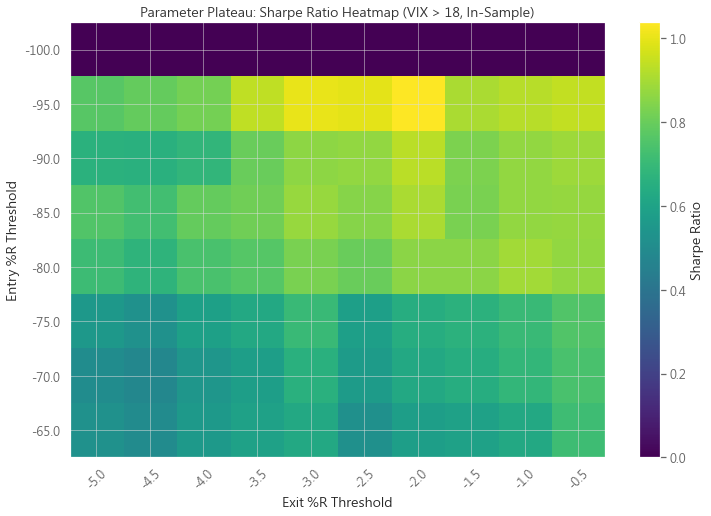

Best Parameters (In-Sample): Entry %R < -95, Exit %R > -2.0, Sharpe: 1.04


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 篩選樣本內資料（2020/01/01 以前）
txf_df['datetime'] = pd.to_datetime(txf_df['datetime'])
txf_in_sample = txf_df[txf_df['datetime'] < '2020-01-01'].copy()

# 假設你已有 settlement_df，欄位是 datetime
rollover_dates = set(pd.to_datetime(settlement_df['datetime']).dt.normalize())

# 參數最佳化函數
def backtest(txf_df, entry_th, exit_th, vix_th=18):
    txf_df = txf_df.copy()
    txf_df['Date'] = txf_df['datetime'].dt.normalize()

    # 初始化欄位（全部 float 或 int）
    txf_df['PositionRaw'] = 0
    txf_df['EntrySignal'] = 0
    txf_df['ExitSignal'] = 0
    txf_df['PnL'] = 0.0
    txf_df['Cost'] = 0.0
    txf_df['NetPnL'] = 0.0
    txf_df['Equity'] = 1_000_000.0
    txf_df['TradeReturn'] = 0.0
    txf_df['TradingDate'] = 0
    txf_df['Rollover'] = 0
    txf_df['EntryPrice'] = np.nan
    txf_df['ExitPrice'] = np.nan

    # 參數
    position = 0
    fee_per_trade = 0.0003
    capital = 1_000_000.0
    contract_size = 200.0
    pending_entry = False
    pending_exit = False

    def side_cost(price):
        return fee_per_trade * contract_size * price

    for i in range(1, len(txf_df)):
        prev_row = txf_df.iloc[i - 1]
        row = txf_df.iloc[i]

        cost_today = 0.0
        pnl = 0.0
        is_rollover = row['Date'] in rollover_dates
        rollover_executed = False

        # 出場處理（隔天開盤）
        if pending_exit:
            exit_price = row['Open']
            pnl += (exit_price - prev_row['Close']) * contract_size
            cost_today += side_cost(exit_price)
            position = 0
            pending_exit = False
            txf_df.at[i, 'ExitPrice'] = exit_price

        # 換倉日處理
        if is_rollover and position > 0:
            exit_price = row['Open']
            pnl += (exit_price - prev_row['Close']) * contract_size
            cost_today += side_cost(exit_price)
            txf_df.at[i, 'ExitPrice'] = exit_price

            entry_price = row['Open']
            cost_today += side_cost(entry_price)
            txf_df.at[i, 'EntryPrice'] = entry_price

            rollover_executed = True
            txf_df.at[i, 'Rollover'] = 1
            pnl += (row['Close'] - row['Open']) * contract_size

        # 策略訊號
        long_signal = (row['%R'] < entry_th) and (row['VIX'] > vix_th)
        exit_signal = (row['%R'] > exit_th)

        if pending_entry and position == 0:
            entry_price = row['Open']
            position = 1
            cost_today += side_cost(entry_price)
            pnl += (row['Close'] - row['Open']) * contract_size
            pending_entry = False
            txf_df.at[i, 'EntryPrice'] = entry_price

        elif position > 0 and not rollover_executed:
            pnl += (row['Close'] - prev_row['Close']) * contract_size

        # 更新資金
        net_pnl = pnl - cost_today
        capital += net_pnl

        txf_df.at[i, 'PnL'] = pnl
        txf_df.at[i, 'Cost'] = cost_today
        txf_df.at[i, 'NetPnL'] = net_pnl
        txf_df.at[i, 'Equity'] = capital
        txf_df.at[i, 'PositionRaw'] = position

        # 產生下一天 pending 訊號
        if i < len(txf_df) - 1:
            if position > 0 and (exit_signal or long_signal):
                pending_exit = True
                txf_df.at[i, 'ExitSignal'] = 1
            if long_signal:
                pending_entry = True
                txf_df.at[i, 'EntrySignal'] = 1

    # 計算每日連續報酬率
    daily_returns = txf_df['Equity'].pct_change().fillna(0)
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() != 0 else 0.0
    return sharpe, txf_df['Equity'].iloc[-1]

# 格點搜尋
entry_th_range = np.arange(-100, -60, 5)
exit_th_range = np.arange(-5, 0, 0.5)

results = []
for entry_th in entry_th_range:
    for exit_th in exit_th_range:
        sharpe, final_equity = backtest(txf_in_sample, entry_th, exit_th, vix_th=18)
        results.append({'entry_th': entry_th, 'exit_th': exit_th, 'sharpe': sharpe, 'final_equity': final_equity})

results_df = pd.DataFrame(results)

# 繪製 Sharpe Heatmap
pivot_sharpe = results_df.pivot(index='entry_th', columns='exit_th', values='sharpe')
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(pivot_sharpe.values, cmap='viridis', aspect='auto')

ax.set_xticks(np.arange(len(exit_th_range)))
ax.set_yticks(np.arange(len(entry_th_range)))
ax.set_xticklabels([f'{x:.1f}' for x in exit_th_range], rotation=45)
ax.set_yticklabels([f'{x:.1f}' for x in entry_th_range])
plt.colorbar(im, label='Sharpe Ratio')
ax.set_xlabel('Exit %R Threshold')
ax.set_ylabel('Entry %R Threshold')
ax.set_title('Parameter Plateau: Sharpe Ratio Heatmap (VIX > 18, In-Sample)')
plt.show()

# 印出最佳參數
best_idx = results_df['sharpe'].idxmax()
best_entry = results_df.loc[best_idx, 'entry_th']
best_exit = results_df.loc[best_idx, 'exit_th']
best_sharpe = results_df.loc[best_idx, 'sharpe']
print(f'Best Parameters (In-Sample): Entry %R < {best_entry}, Exit %R > {best_exit}, Sharpe: {best_sharpe:.2f}')


<Figure size 864x576 with 0 Axes>

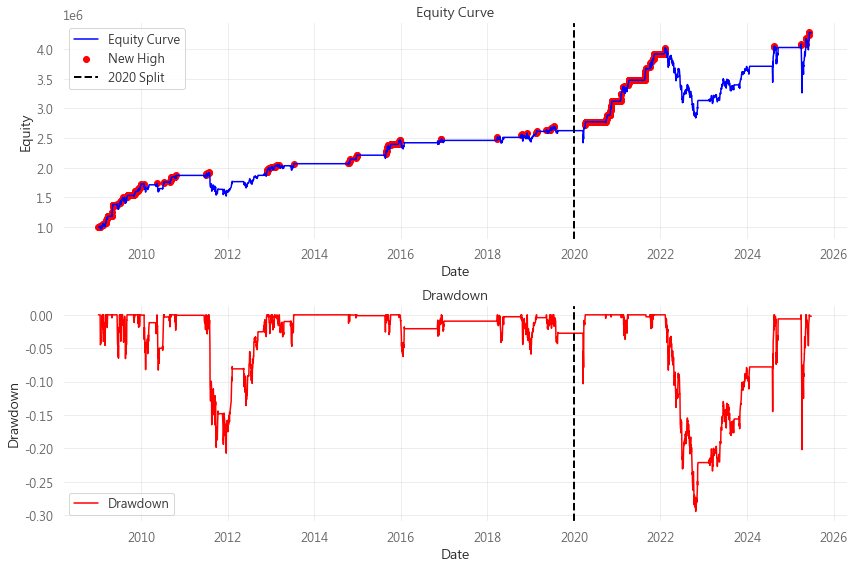

In [33]:
# Visualize Equity Curve and Drawdowns 
# 先計算回撤
txf_df['Equity_High'] = txf_df['Equity'].cummax()
txf_df['Drawdown'] = txf_df['Equity'] / txf_df['Equity_High'] - 1

plt.figure(figsize=(12, 8)) 

# Equity Curve 計算累積最大值（創新高）
txf_df['Equity_High'] = txf_df['Equity'].cummax()
new_high_idx = txf_df[txf_df['Equity'] == txf_df['Equity_High']].index

split_date = pd.Timestamp("2020-01-01")

plt.figure(figsize=(12, 8))

# Equity Curve
plt.subplot(2, 1, 1)
plt.plot(txf_df['datetime'], txf_df['Equity'], label='Equity Curve', color='blue')
plt.scatter(txf_df.loc[new_high_idx, 'datetime'],
            txf_df.loc[new_high_idx, 'Equity'],
            color='red', marker='o', label='New High')

# 標出樣本內外切割點
plt.axvline(split_date, color='black', linestyle='--', linewidth=2, label='2020 Split')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()

# Drawdowns
plt.subplot(2, 1, 2)
plt.plot(txf_df['datetime'], txf_df['Drawdown'], label='Drawdown', color='red')

# 標出樣本內外切割點
plt.axvline(split_date, color='black', linestyle='--', linewidth=2)
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
# 報酬可視化
txf_df['date'] = pd.to_datetime(txf_df['date'])
txf_df['Year'] = txf_df['date'].dt.year
txf_df['Month'] = txf_df['date'].dt.month
txf_df['Day'] = txf_df['date'].dt.day


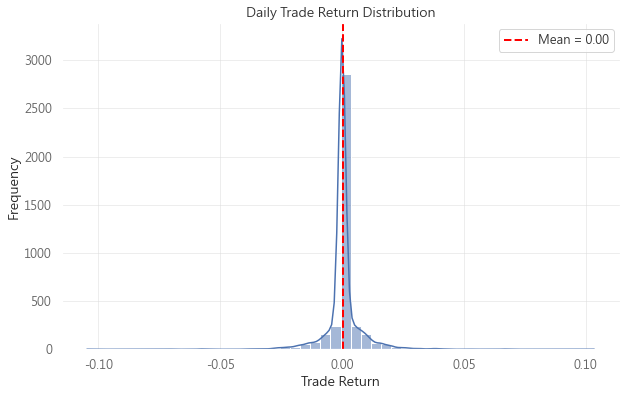

In [43]:
# 每日報酬直方圖
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(txf_df['TradeReturn'], bins=50, kde=True)

# 計算平均值
mean_return = txf_df['TradeReturn'].mean()

# 畫平均線
plt.axvline(mean_return, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_return:.2f}')

plt.title('Daily Trade Return Distribution')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

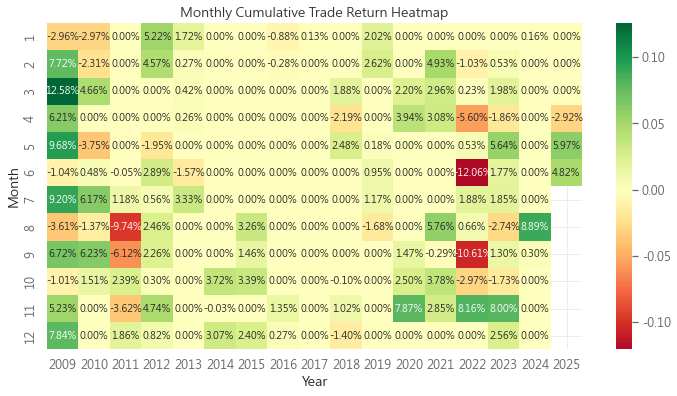

In [36]:
# 每月報酬熱力圖
monthly_return = txf_df.groupby(['Year','Month'])['TradeReturn'].sum().unstack(level=0)

plt.figure(figsize=(12,6))
sns.heatmap(monthly_return, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title('Monthly Cumulative Trade Return Heatmap')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


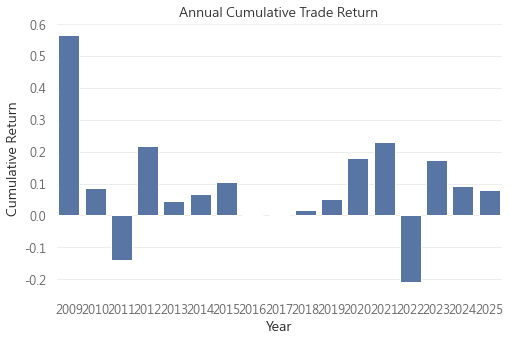

In [37]:
# 每年報酬直方圖
annual_return = txf_df.groupby('Year')['TradeReturn'].sum()

plt.figure(figsize=(8,5))
sns.barplot(x=annual_return.index, y=annual_return.values)
plt.title('Annual Cumulative Trade Return')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.show()


In [38]:
# 計算策略單利累積報酬
txf_df['CumsumReturn'] = txf_df['TradeReturn'].cumsum()

market_df['Return'] = market_df['Close'].pct_change().shift(1)
market_df['SimpleReturn'] = market_df['Return'].cumsum()

# # 計算0050報酬 (買進手續費 0.1425% + 賣出交易稅 0.3% = 總一次性成本 ≈ 0.4425%)
# # 0050每年管理費率約 0.42% 每日費率約 0.42% / 252 = 0.0000166667
# df_0050['Return'] = (df_0050['Close'].pct_change().shift(1)) * (1 - 0.000035)
# df_0050['SimpleReturn'] = df_0050['Return'].cumsum()

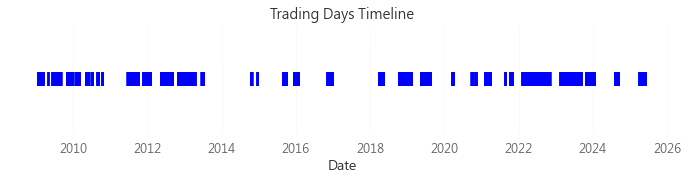

In [39]:
import matplotlib.pyplot as plt

# trading_date(包含holding)
trading_dates = txf_df.loc[txf_df['TradingDate'] == 1, 'datetime']

# 建立圖表
plt.figure(figsize=(12, 2))
plt.scatter(trading_dates, [1] * len(trading_dates), marker='|', s=200, color='blue')

# 美化
plt.title("Trading Days Timeline", fontsize=14)
plt.xlabel("Date")
plt.yticks([])  # 隱藏 y 軸
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()


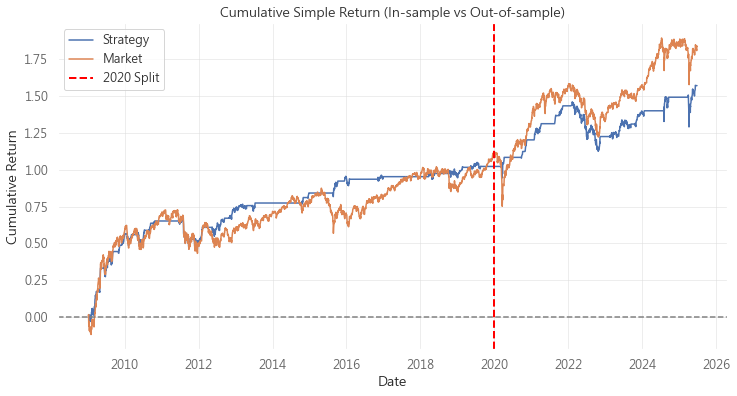

In [40]:
# 畫圖
plt.figure(figsize=(12,6))

# 策略 vs. 市場
plt.plot(txf_df['datetime'], txf_df['CumsumReturn'], label='Strategy')
plt.plot(market_df['datetime'], market_df['SimpleReturn'], label='Market')

# 標出 y=0
plt.axhline(0, color='gray', linestyle='--')

# 標出 2020 年切點
plt.axvline(pd.Timestamp("2020-01-01"), color='red', linestyle='--', linewidth=2, label='2020 Split')

plt.legend()
plt.title('Cumulative Simple Return (In-sample vs Out-of-sample)')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

c:\Users\herby\AppData\Local\Programs\Python\Python3

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-01-05  2009-01-05
End Period                 2025-06-27  2025-06-27
Risk-Free Rate             0.0%        0.0%
Time in Market             38.0%       100.0%

Cumulative Return          327.5%      369.97%
CAGR﹪                     9.21%       9.84%

Sharpe                     0.81        0.61
Prob. Sharpe Ratio         99.93%      99.22%
Smart Sharpe               0.8         0.6
Sortino                    1.2         0.85
Smart Sortino              1.17        0.83
Sortino/√2                 0.85        0.6
Smart Sortino/√2           0.83        0.59
Omega                      1.28        1.28

Max Drawdown               -29.44%     -31.51%
Longest DD Days            917         1217
Volatility (ann.)          12.04%      18.67%
R^2                        0.0         0.0
Information Ratio          -0.0        -0.0
Calmar                     0.31        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-02-11,2022-10-25,2024-08-16,917,-29.435959,-28.138611
2,2011-07-28,2011-12-19,2012-11-26,487,-20.710615,-19.375658
3,2025-04-07,2025-04-09,2025-05-13,36,-20.176964,-15.297975
4,2019-07-17,2020-03-19,2020-04-06,264,-10.318841,-5.467012
5,2010-05-14,2010-05-25,2010-07-09,56,-8.270956,-7.464381


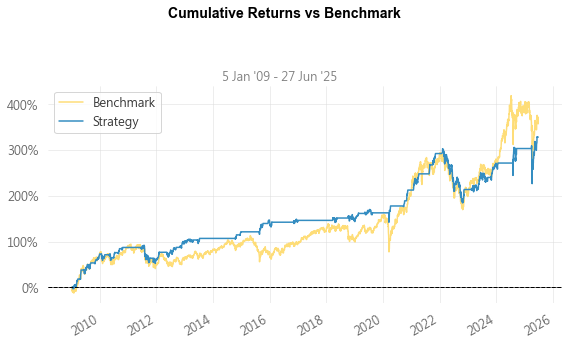

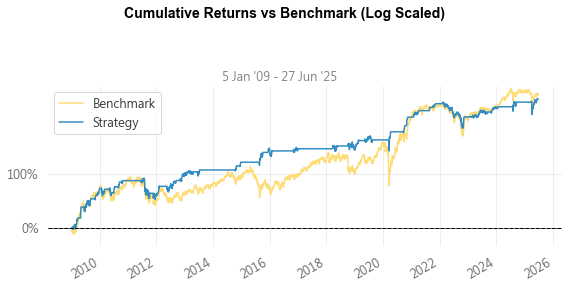

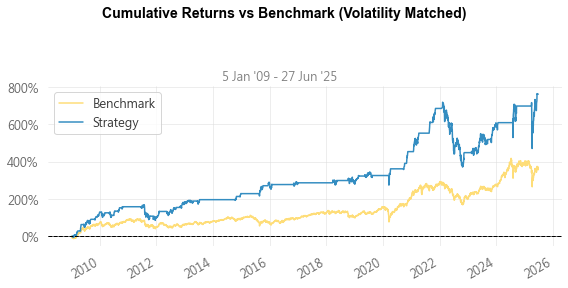

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:376: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:377: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:383: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\wrappers.py:386: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.



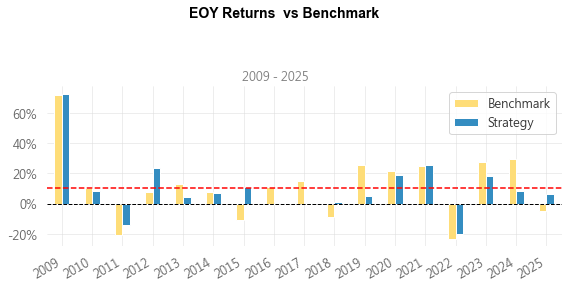

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:325: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\herby\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\_plotting\core.py:326: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



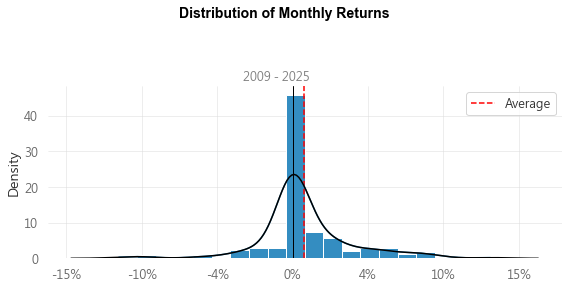

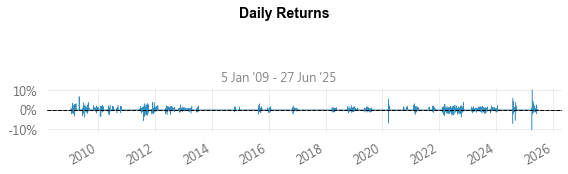

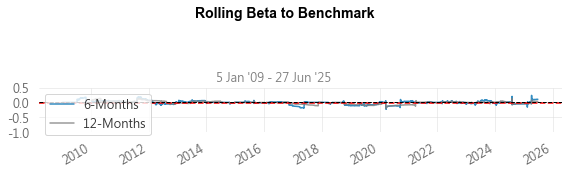

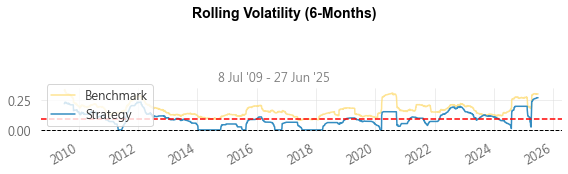

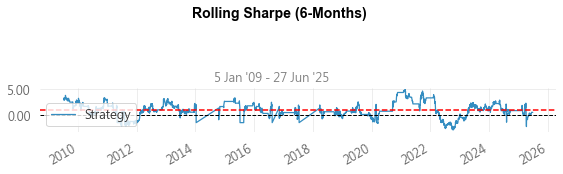

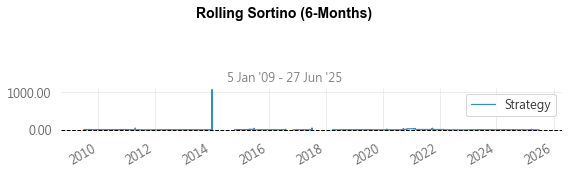

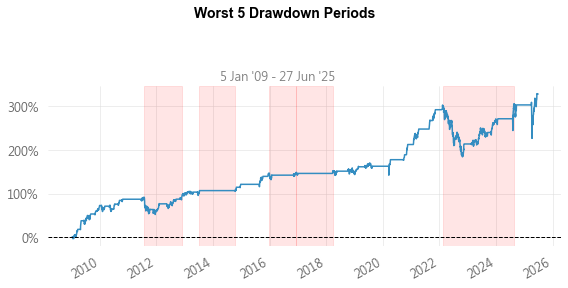

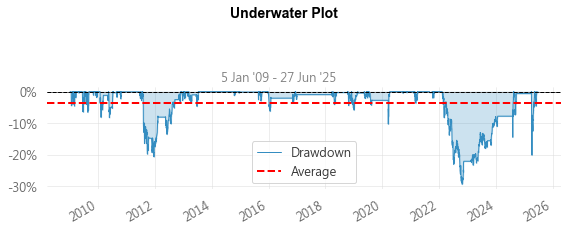

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [41]:
# !pip install quantstat == 0.0.59
# 設定字體（Windows 用微軟正黑體）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False  # 避免負號變方框

# 準備回測結果
strategy_returns = txf_df.set_index('datetime')["TradeReturn"]
benchmark = market_df.set_index('datetime')["Return"]

# 產生完整報告
qs.reports.full(strategy_returns, benchmark=benchmark)
